In [1]:
import django
import pandas as pd
django.setup()

In [2]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from sch.models import *
import datetime as dt
from django.db.models import CharField
from django.test import RequestFactory
from sch.actions import *
from sch.views2 import *

In [3]:
shift = Shift.objects.get(name='MI')
all_mi_slots = list(Slot.objects.filter(shift=shift).values_list('employee__name',flat=True))
print(
    all_mi_slots
)
mi_tallies = tally(all_mi_slots)
print (
    "\n======TALLIES======\n",
    mi_tallies
)

[None, 'Sabrina', 'Elisia', 'Sabrina', 'Cheryl', 'Leslie', 'Tiffany', 'Cheryl', 'Tiffany', 'Elisia', 'Elisia', 'Josh', 'Elisia', None, None, 'Tiffany', 'Tiffany', 'David', 'David', 'David', 'Cheryl', 'Cheryl', 'Tiffany', 'Elisia', 'Elisia', 'Elisia', 'Elisia', 'David', None, 'Sabrina', 'Elisia', 'Elisia', 'Trisha', 'Josh', 'Cheryl', 'Tiffany', 'David', 'Sabrina', 'Cheryl', 'Esperanza', 'Cheryl', 'Sabrina', 'David', 'Leslie', 'Josh', 'Leslie', 'Elisia', 'Elisia', None, 'Tiffany', 'David', 'Leslie', 'Cheryl', 'Cheryl', 'Elisia', None, 'Elisia', 'Elisia', 'Elisia', 'Cheryl', 'David', 'Elisia', None, 'Sabrina', 'David', 'David', 'Leslie', 'Cheryl', 'David', 'Elisia', None, 'Tiffany', 'Josh', 'Elisia', 'David', 'David', 'Trisha', 'Cheryl', 'Cheryl', 'Elisia', 'Cheryl', 'David', 'Elisia', None, 'David', 'Elisia', 'Leslie', 'Leslie', 'David', None, 'Tiffany', 'Josh', 'David', 'Elisia', 'Cheryl', 'Josh', 'Leslie', 'David', 'Elisia', 'Jaden', 'Elisia', 'Cheryl', None, 'Cheryl', 'Cheryl', None, 

<AxesSubplot:ylabel='count'>

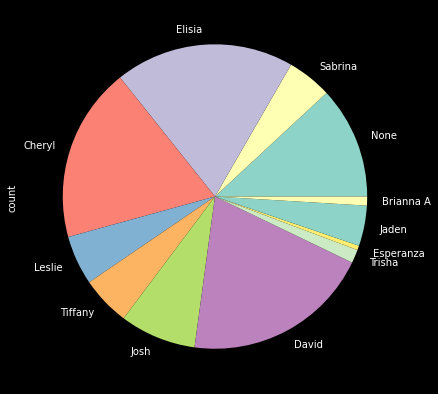

In [4]:
df = pd.DataFrame.from_dict(mi_tallies, orient='index', columns=['count'])
df.plot(kind='pie', y='count', figsize=(7, 7), legend=False)

In [17]:
from pprint import pprint
jts = Employee.objects.get(name='Josh')
sch = Schedule.objects.last()

sch

<Schedule: 2022-S6A>

In [20]:
wd = sch.workdays.all()[5]
day0free = wd.free_today()
day1free = wd.nextWD().free_today()
day0free.intersection(day1free)

<EmployeeManager []>

In [59]:
wd.slots.all()

def giveEmployeeMostPrefdSlotOnDay (wd,empl):
    slots = wd.slots.empty()
    print ()
    
giveEmployeeMostPrefdSlotOnDay(wd, jts)

<ShiftPreferenceManager [(2,), (0,), (-1,), (2,), (2,), (0,), (-1,), (-2,), (0,)]>


In [79]:
empls = Employee.objects.annotate(max_shift_pref=Max(Subquery(ShiftPreference.objects.filter(employee=OuterRef('pk')).values('score')))).values(
    'name','max_shift_pref'
).order_by('-max_shift_pref')
empls

<EmployeeManager [{'name': 'Amanda', 'max_shift_pref': 2}, {'name': 'Cheryl', 'max_shift_pref': 2}, {'name': 'Jaden', 'max_shift_pref': 2}, {'name': 'Josh', 'max_shift_pref': 2}, {'name': 'Tiffany', 'max_shift_pref': 2}, {'name': 'David', 'max_shift_pref': 1}, {'name': 'Esperanza', 'max_shift_pref': 1}, {'name': 'Leslie', 'max_shift_pref': 1}, {'name': 'Danica', 'max_shift_pref': 0}, {'name': 'Brittanie', 'max_shift_pref': -2}, {'name': 'Sabrina', 'max_shift_pref': -2}, {'name': 'Brianna A', 'max_shift_pref': None}, {'name': 'Elisia', 'max_shift_pref': None}, {'name': 'Lindsay', 'max_shift_pref': None}, {'name': 'Michael', 'max_shift_pref': None}, {'name': 'Mona', 'max_shift_pref': None}, {'name': 'Trisha', 'max_shift_pref': None}]>

In [93]:
ep = Shift.objects.get(name="EP")
ep_sps = ep.shift_prefs.all().order_by('-score').values('employee__name','score')
slot = Slot.objects.filter(shift=ep,employee=None)[15]
slot.workday.printSchedule
slot.workday.tdo()

MI Elisia
7C David
7P Brianna A
EI Trisha
EP None
3 Mona
N Michael


AttributeError: 'Workday' object has no attribute 'tdo'